#**WHAT I DID IN THIS NOTEBOOK:**

**In previous notebooks I used MAE as a metric of measure. However I then changed to using accuracy as a measure by changing the regression problem into classification where I found how I could predict datapoints of the closing price by creating EMA, normalizing the dataset and stacking X and finding Y based on X**

**I then used this dataset to split into test, train and validate sets.** 

**I stacked the OHLCV data and used that as X and closing prices as Y hence genetrated  the classification problem.** 

**Then I predicted the accuacy.** 

**I used hyperparemeter tuning for the LSTM model and ran a GRU cell with some hyperparameter too.**


**Importing packages from keras**

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
googlepath = "/content/drive/My Drive/"

In [6]:
!python /content/drive/'My Drive'/utils.py install

python3: can't open file '/content/drive/My Drive/utils.py': [Errno 2] No such file or directory


In [7]:
from google.colab import files
src = list(files.upload().values())[0]

IndexError: ignored

In [8]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
open('utils.py','wb').write(src)
from utils import *

NameError: ignored

**utils.py is a python package having tickers for time series data. You can** 

**upload it using the above command. Recommend to download it using**
https://pypi.org/project/python-utils/ **and storing in drive.** 


In [10]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [11]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
link = 'https://drive.google.com/open?id=1CQDa0VJP0cEKxO9hRpyxngnJIxYaVwTV' # The shareable link

In [13]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1CQDa0VJP0cEKxO9hRpyxngnJIxYaVwTV


In [43]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AMZN.csv')  

data_original = list(files.upload().values())[::-1]
data_original = pd.read_csv('AMZN.csv')[::-1]


Saving AMZN.csv to AMZN (2).csv


In [32]:
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM, GRU
from keras.layers import Conv1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers import Bidirectional
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
sns.despine()


<Figure size 432x288 with 0 Axes>

In [44]:
data_original.head()

,Date,Open,High,Low,Close,Volume
45556,11/10/2017,55.23,55.32,54.370,54.80,5032662
45555,11/9/2017,55.06,55.50,54.910,55.45,3644007
45554,11/8/2017,54.98,55.35,54.720,55.25,3712978
45553,11/7/2017,55.15,55.26,54.685,55.16,4843996
45552,11/6/2017,55.32,55.40,55.010,55.01,3134081


In [33]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/parser.py", line 12, in <module>
    from pip._internal.configuration import Configuration, ConfigurationError
  File "/usr/local/lib/p

**Imported all keras files**

# NEXT STEPS

**DATA MANIPULATION, NORMALIZATION AND EMA(Exponential moving average) CALCULATION**

**WHAT I AM TRYING TO DO:** 

**INSTEAD OF MAE I WILL TRY TO MEASURE ACCURACY OF MY LSTM NETWORK BY CONVERTING THE REGRESSION PROBLEM INTO CLASSIFICATION.** 

**I WILL TRY TO PREDICT CLOSING PRICES DATAPOINT TO DATAPOINT AND SEE HOW WELL MY NORMALIZED DATASET CAN PREDICT THE CLOSING VALUES**

In [37]:
def create_Xt_Yt(X, y, percentage=0.9):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(y) * percentage):]
    return X_train, X_test, Y_train, Y_test


In [45]:
data_original = pd.read_csv('AMZN.csv')[::-1]

openp = data_original['Open'].tolist()  # convert all OHLCV data into list formats so appending will be easy
highp = data_original.loc[:, 'High'].tolist()
lowp = data_original.loc[:, 'Low'].tolist()
closep = data_original.loc[:, 'Close'].tolist()
volumep = data_original.loc[:, 'Volume'].tolist()

WINDOW = 30   # Keep a window of 30 days for EMA
EMB_SIZE = 5  
STEP = 1
FORECAST = 1 # One day ahead forecast as before 
X, Y = [], []
for i in range(0, len(data_original), STEP):  # create a counter for data with step size 1
    try:
        o = openp[i:i+WINDOW]  # declare a window and sample through each stock price
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)  # normalize the stock values by fiding differnce in array lenth and mean and dividing by standard dev
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

        x_i = closep[i:i+WINDOW]           # create train for close price and add forecast for output price
        y_i = closep[i+WINDOW+FORECAST]  

        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close: 
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v))   # do not consider any tickers that we conidered in former model.
                                                  # by creating close price treshold we create our own theshold indicator

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))  # reshape train so that can be fed into LSTM network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))


**My Algorithm:**

**1. create train for close price and add forecast for output price**

**2. create train for close price and add forecast for output price**

**3. do not consider any tickers that we conidered in former model.**

**4. by creating close price treshold we create our own theshold indicator**

**USE LSTM NETWORK ARCHITECTURE**

In [46]:

def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [48]:
from keras import backend as K
nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=20, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/20


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
140/143 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.5256 - mean_pred: 0.2371

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
143/143 [==============================] - 10s 11ms/step - loss: 0.4747 - accuracy: 0.5262 - mean_pred: 0.2395 - val_loss: 0.4551 - val_accuracy: 0.5358 - val_mean_pred: 0.3521
Epoch 2/20
143/143 [==============================] - 1s 9ms/step - loss: 0.4458 - accuracy: 0.5600 - mean_pred: 0.3115 - val_loss: 0.4328 - val_accuracy: 0.5985 - val_mean_pred: 0.3071
Epoch 3/20
143/143 [==============================] - 1s 6ms/step - loss: 0.4031 - accuracy: 0.6493 - mean_pred: 0.3998 - val_loss: 0.3901 - val_accuracy: 0.6866 - val_mean_pred: 0.3967
Epoch 4/20
143/143 [==============================] - 1s 8ms/step - loss: 0.3810 - accuracy: 0.6811 - mean_p

**TRAINING ACCURACY AT 70.6%**

In [49]:
nn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [50]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

570/570 [==============================] - 2s 4ms/step - loss: 0.3495 - accuracy: 0.6940 - mean_pred: 0.4402
Test accuracy: [0.3494596481323242, 0.6940478682518005, 0.44021180272102356]


**TESTING ACCURACY AT 67.18%**

In [51]:
#Plotting training data loss and validation data loss
plt.plot(nn_history.history['acc'], label = 'trained data')
plt.plot(nn_history.history['val_acc'], label = 'validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

KeyError: ignored

**A GOOD MODEL. NORMALIZED VALUES DIFFERENCE AT 0.025 SO NOT OVERFIT OR UNDERFIT.**

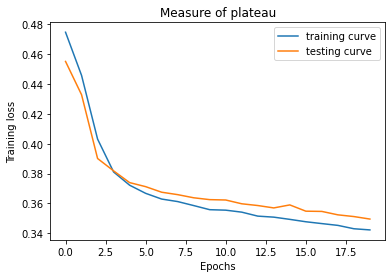

In [52]:
#plateau:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

**SUMMARY OF THIS STRATEGY: 
        great results compared to just pure stock prediction and even 
        previous simple moving average algorithm
I will now try to find the best LSTM model by tweaking epoch, cost function, actvation function and other parameters. 
Go down for other network architectures-mainly GRU and conv1D**

**HYPERPARAMETER TUNING**

**For LSTM: change activation function, cost functionand other params. We know which ones are good for seq model by previous analysis. Trying a few combinations based on past analysis:**

**1.elu and selu with rmsprop and sgd along with mse and logcosh**

**2.will try epochs 100 and 50** 

**3. will try initialzers random uniform and zeros**

In [53]:
#elu with mse and rmsprop. epoch of 100. 
#initializer random uniform.  
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="elu",
                dropout=0.10, loss="mse", optimizer="rmsprop"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [54]:
nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=100, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/100


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
135/143 [===========================>..] - ETA: 0s - loss: 0.2750 - accuracy: 0.5321 - mean_pred: 0.4328

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
143/143 [==============================] - 4s 9ms/step - loss: 0.2735 - accuracy: 0.5339 - mean_pred: 0.4365 - val_loss: 0.2454 - val_accuracy: 0.5312 - val_mean_pred: 0.5045
Epoch 2/100
143/143 [==============================] - 1s 6ms/step - loss: 0.2410 - accuracy: 0.5902 - mean_pred: 0.4984 - val_loss: 0.2326 - val_accuracy: 0.6013 - val_mean_pred: 0.5075
Epoch 3/100
143/143 [==============================] - 1s 6ms/step - loss: 0.2228 - accuracy: 0.6501 - mean_pred: 0.4985 - val_loss: 0.2160 - val_accuracy: 0.6502 - val_mean_pred: 0.5033
Epoch 4/100
143/143 [==============================] - 1s 6ms/step - loss: 0.2089 - accuracy: 0.6829 - mean_

In [55]:
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4864      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [56]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

570/570 [==============================] - 2s 3ms/step - loss: 0.1993 - accuracy: 0.6977 - mean_pred: 0.4997
Test accuracy: [0.19926731288433075, 0.6976718902587891, 0.4997418224811554]


**Test Accuracy is at 68.39%**

**Plotting training data loss and validation data loss**

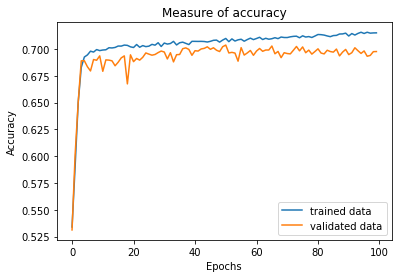

In [58]:
plt.plot(nn_history.history['accuracy'], label='trained data')
plt.plot(nn_history.history['val_accuracy'], label='validated data')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

**Model is perfectly fit if not slightly overfit but we trained for 100 epochs so that is expected**

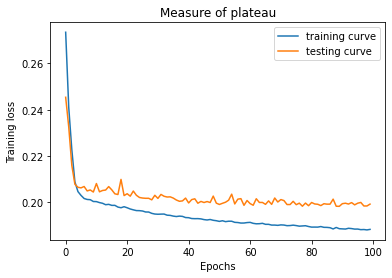

In [59]:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

**Measuring the training loss to recheck model**

**More Hyperparameter tuning: selu with logcosh amd sgd. epoch of 35. initializer zeros**

In [60]:
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="selu",
                dropout=0.10, loss="logcosh", optimizer="sgd"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [61]:
nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=35, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/35


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
142/143 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.5243 - mean_pred: 0.1427

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
143/143 [==============================] - 5s 19ms/step - loss: 0.1717 - accuracy: 0.5242 - mean_pred: 0.1435 - val_loss: 0.1448 - val_accuracy: 0.5298 - val_mean_pred: 0.2485
Epoch 2/35
143/143 [==============================] - 1s 6ms/step - loss: 0.1334 - accuracy: 0.5312 - mean_pred: 0.3188 - val_loss: 0.1262 - val_accuracy: 0.5402 - val_mean_pred: 0.3721
Epoch 3/35
143/143 [==============================] - 1s 6ms/step - loss: 0.1232 - accuracy: 0.5310 - mean_pred: 0.4087 - val_loss: 0.1212 - val_accuracy: 0.5400 - val_mean_pred: 0.4351
Epoch 4/35
143/143 [==============================] - 1s 6ms/step - loss: 0.1205 - accuracy: 0.5332 - mean_pr

In [62]:
nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4864      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
 activation_3 (Activation)   (None, 2)                 0         
                                                                 
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [63]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

570/570 [==============================] - 2s 3ms/step - loss: 0.1176 - accuracy: 0.5642 - mean_pred: 0.4992
Test accuracy: [0.11755018681287766, 0.5642433762550354, 0.499165803194046]


**Accuracy at 52.53%**

**Plotting training data loss and validation data loss**

**As seeb data is overfit and doesn't do great with selu and logcosh because logcosh could remove non-linearity of data**

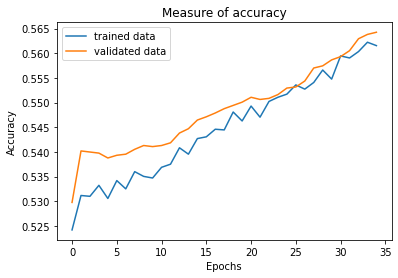

In [65]:
plt.plot(nn_history.history['accuracy'], label='trained data')
plt.plot(nn_history.history['val_accuracy'], label='validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

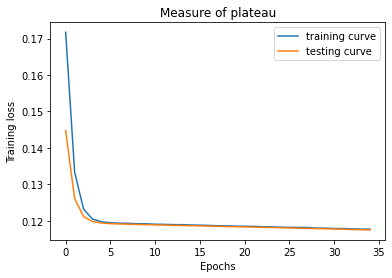

In [66]:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

**Not a lot of training and testing loss**

**More Hyperparamete tuning: Create a LSTM model with relu as activation function, mae as loss function, adam as optimizer and train for 50 epochs.**

In [67]:

def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [69]:
nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=50, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
138/143 [===========================>..] - ETA: 0s - loss: 0.4740 - accuracy: 0.5258 - mean_pred: 0.2987

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
143/143 [==============================] - 4s 9ms/step - loss: 0.4733 - accuracy: 0.5264 - mean_pred: 0.3000 - val_loss: 0.4545 - val_accuracy: 0.5336 - val_mean_pred: 0.3436
Epoch 2/50
143/143 [==============================] - 1s 6ms/step - loss: 0.4431 - accuracy: 0.5590 - mean_pred: 0.2926 - val_loss: 0.4322 - val_accuracy: 0.5915 - val_mean_pred: 0.2486
Epoch 3/50
143/143 [==============================] - 1s 6ms/step - loss: 0.4279 - accuracy: 0.6033 - mean_pred: 0.2533 - val_loss: 0.4265 - val_accuracy: 0.6093 - val_mean_pred: 0.2463
Epoch 4/50
143/143 [==============================] - 1s 6ms/step - loss: 0.4236 - accuracy: 0.6206 - mean_pre

In [68]:
nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4864      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
 activation_3 (Activation)   (None, 2)                 0         
                                                                 
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [70]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

570/570 [==============================] - 2s 4ms/step - loss: 0.3326 - accuracy: 0.6961 - mean_pred: 0.4584
Test accuracy: [0.33257362246513367, 0.6961343884468079, 0.45835548639297485]


**Test Accuracy at 66.94%**

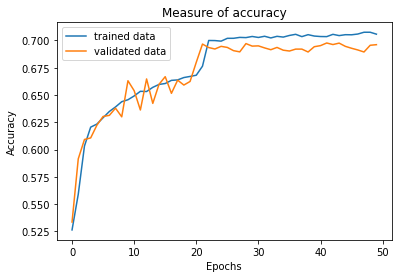

In [72]:
#Plotting training data loss and validation data loss
plt.plot(nn_history.history['accuracy'], label='trained data')
plt.plot(nn_history.history['val_accuracy'], label='validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

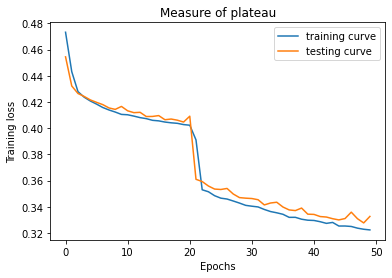

In [73]:
#plateau:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

**USE GRU NETWORK ARCHITECTURE**

**Created a GRU network in Keras and then run it for some time. Here I haven't performed much parameter tuning. Trained for 20 epochs on relu, mae and adam.** 


In [74]:
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(GRU(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

nn_model = build_model(X_train, output_size=2, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(X_train, Y_train,
                            epochs=20, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/20


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
141/143 [============================>.] - ETA: 0s - loss: 0.4441 - accuracy: 0.5880 - mean_pred: 0.3160

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
143/143 [==============================] - 4s 8ms/step - loss: 0.4438 - accuracy: 0.5887 - mean_pred: 0.3179 - val_loss: 0.4025 - val_accuracy: 0.6490 - val_mean_pred: 0.4451
Epoch 2/20
143/143 [==============================] - 1s 7ms/step - loss: 0.3841 - accuracy: 0.6797 - mean_pred: 0.4299 - val_loss: 0.3838 - val_accuracy: 0.6823 - val_mean_pred: 0.4123
Epoch 3/20
143/143 [==============================] - 1s 8ms/step - loss: 0.3739 - accuracy: 0.6893 - mean_pred: 0.4175 - val_loss: 0.3771 - val_accuracy: 0.6830 - val_mean_pred: 0.4037
Epoch 4/20
143/143 [==============================] - 1s 8ms/step - loss: 0.3678 - accuracy: 0.6946 - mean_pre

In [75]:
nn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3744      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
 activation_5 (Activation)   (None, 2)                 0         
                                                                 
Total params: 3,810
Trainable params: 3,810
Non-trainable params: 0
_________________________________________________________________


In [76]:
acc = nn_model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

570/570 [==============================] - 2s 3ms/step - loss: 0.3518 - accuracy: 0.6953 - mean_pred: 0.4304
Test accuracy: [0.35182514786720276, 0.6952558755874634, 0.430422306060791]


Accuracy at 66.81%

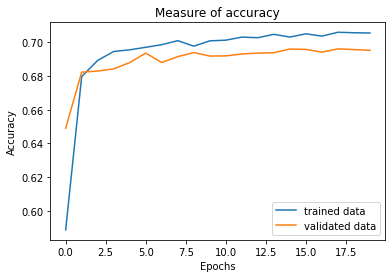

In [77]:
#Plotting training data loss and validation data loss
plt.plot(nn_history.history['accuracy'], label='trained data')
plt.plot(nn_history.history['val_accuracy'], label='validated data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Measure of accuracy')
plt.show()

**A great model for both accuracy and loss. GRU does a good job like LSTM network.**

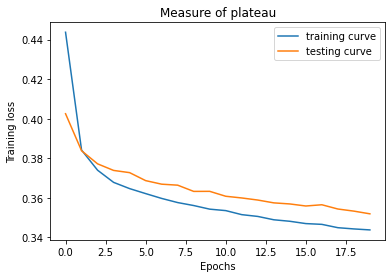

In [78]:
plt.plot(nn_history.history['loss'], label = 'training curve')
plt.plot(nn_history.history['val_loss'], label = 'testing curve')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

#**CONCLUSIONS:**

**I found that LSTM and GRU can predict Closing prices of Amazon Data on an average of 65% of the time(best model at 75% worst at 58%) if you normalize the data, stack input data and perform hyperparameter tuning.** 
